In [1]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from preprocess import extract_images
from dataset import get_full_list, ChineseCharacterDataset
from models import CVAE
from utils import visualize_images, show_images
from loss import vae_loss

In [2]:
%load_ext autoreload
%autoreload 2

### Loading and Preprocessing:

In [3]:
# Set the directory and load the dataset
image_dir = './dataset'
full_data_list = get_full_list(image_dir)

In [4]:
train_size = int(0.01*len(full_data_list))
print("Training Set Size:", train_size)

Training Set Size: 2435


In [10]:
train_data_cols = ChineseCharacterDataset(full_data_list[:train_size], cond_type='Row', rows=[20,43])

# Create data loaders
train_loader_cols = DataLoader(train_data_cols, batch_size=32, shuffle=False)

### Model: 

In [11]:
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, condition_dim):
        super(CVAE, self).__init__()
        self.z_dim = z_dim
        self.condition_dim = condition_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim + condition_dim, 512),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)
        
        # Condition encoder
        self.condition_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Fully connected layer for condition encoding
        self.fc_condition = None
                                      
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def initialize_fc_condition(self, condition):
        with torch.no_grad():
            sample_output = self.condition_encoder(condition)
            output_size = (min(sample_output.size(2), 4), min(sample_output.size(3), 4))
            fc_input_dim = 128 * output_size[0] * output_size[1]
            self.fc_condition = nn.Linear(fc_input_dim, self.condition_dim).to(condition.device)
            nn.init.xavier_normal_(self.fc_condition.weight)
            nn.init.zeros_(self.fc_condition.bias)
        
    def forward_condition_encoder(self, condition):
        if self.fc_condition is None:
            self.initialize_fc_condition(condition)
        
        _, _, h, w = condition.shape
        if h < 8 or w < 8:
            pad_h = max(0, 8 - h)
            pad_w = max(0, 8 - w)
            condition = F.pad(condition, (0, pad_w, 0, pad_h))            
            
        # Forward pass through the condition encoder
        x = self.condition_encoder(condition)
        batch_size = x.size(0)
        
        # Dynamically determine the size of the adaptive pooling
        output_size = (min(x.size(2), 4), min(x.size(3), 4))
        
        x = nn.AdaptiveAvgPool2d(output_size)(x)  # Adaptive pooling to a fixed size or smaller
        x = x.view(batch_size, -1)  # Flatten
        x = self.fc_condition(x)  # Fully connected layer to transform to condition_dim

        return x
        
    def encode(self, x, cond_encoded):
        x_flat = x.view(x.size(0), -1)
        # Concatenate the condition with the input image
        x_cond = torch.cat([x_flat, cond_encoded], dim=1)
        h1 = self.encoder(x_cond)
        return self.fc_mu(h1), self.fc_logvar(h1)   

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, cond_encoded):
        # Concatenate z with the encoded condition
        z_cond = torch.cat([z, cond_encoded], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, condition):
        cond_encoded = self.forward_condition_encoder(condition)
        mu, logvar = self.encode(x, cond_encoded)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, cond_encoded), mu, logvar

### Training:

In [12]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [13]:
# Train
def train(model, train_data_set, input_dim, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, condition) in enumerate(train_data_set):
            data = data.to(device)
            condition = condition.to(device)
            optimizer.zero_grad()
            reconstructed_batch, mu, logvar = model(data, condition)
            loss = vae_loss(reconstructed_batch.view(data.shape[0],1,64,64), data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_data_set.dataset)}')
    print(f'Final Loss: {train_loss/len(train_data_set.dataset)}')

In [14]:
input_dim = 64 * 64
z_dim = 50
condition_dim = 50
hidden_dim = 6400*8
learning_rate = 1e-4

num_epochs = 100

model_cols = CVAE(input_dim, hidden_dim, z_dim, condition_dim).to(device)
optimizer = optim.Adam(model_cols.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train(model_cols, train_loader_cols, input_dim, optimizer, scheduler, num_epochs) 

Epoch 1, Loss: 1694.806695970226
Epoch 2, Loss: 1672.708698023614
Epoch 3, Loss: 1661.3063183794277
Epoch 4, Loss: 1614.939937997305
Epoch 5, Loss: 1558.555227918057
Epoch 6, Loss: 1522.3005283864861
Epoch 7, Loss: 1492.0066215750128
Epoch 8, Loss: 1470.239341030865
Epoch 9, Loss: 1451.5895068660163
Epoch 10, Loss: 1436.4626263314938
Epoch 11, Loss: 1414.123906931789
Epoch 12, Loss: 1402.0362713760908
Epoch 13, Loss: 1392.1135561713938
Epoch 14, Loss: 1383.2640592915811
Epoch 15, Loss: 1374.5582358107674
Epoch 16, Loss: 1366.0436403121791
Epoch 17, Loss: 1356.4402955354851
Epoch 18, Loss: 1348.3629133847214
Epoch 19, Loss: 1341.2154787161512
Epoch 20, Loss: 1333.9570767694431
Epoch 21, Loss: 1323.4308486468494
Epoch 22, Loss: 1318.1028780520085
Epoch 23, Loss: 1313.147061489348
Epoch 24, Loss: 1307.269313779357
Epoch 25, Loss: 1302.721431135299
Epoch 26, Loss: 1298.5795615695586
Epoch 27, Loss: 1294.2355418618454
Epoch 28, Loss: 1289.816908969135
Epoch 29, Loss: 1285.4456284289977
Epoc

### Generating Images:

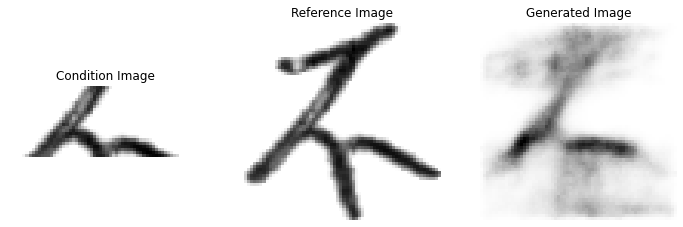

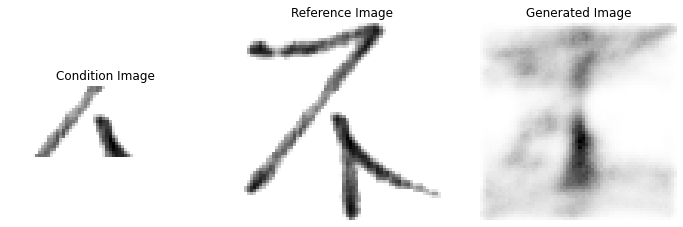

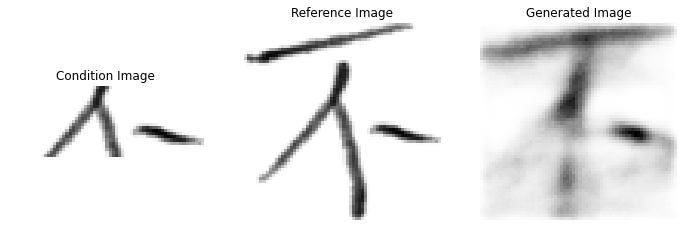

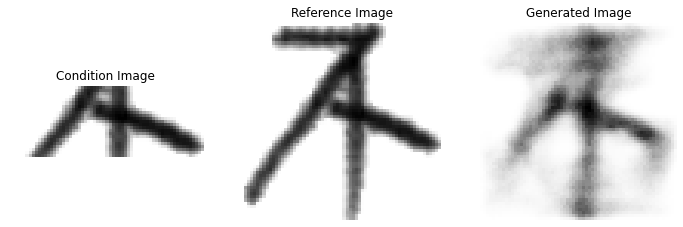

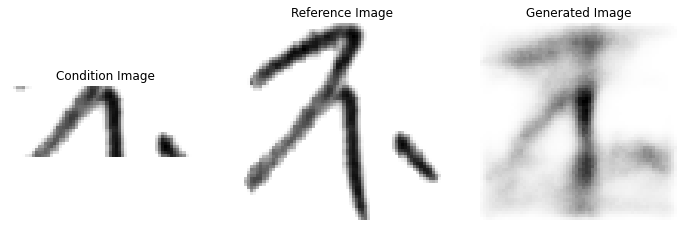

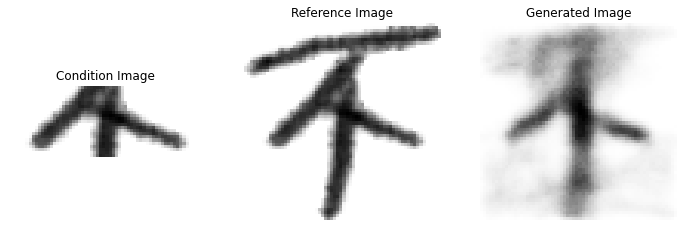

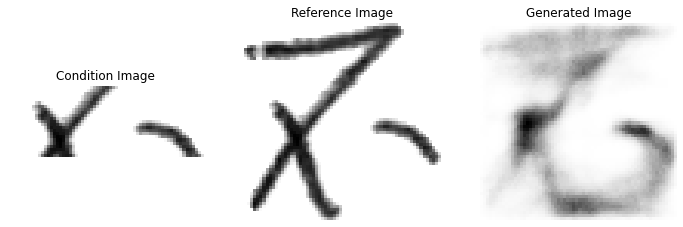

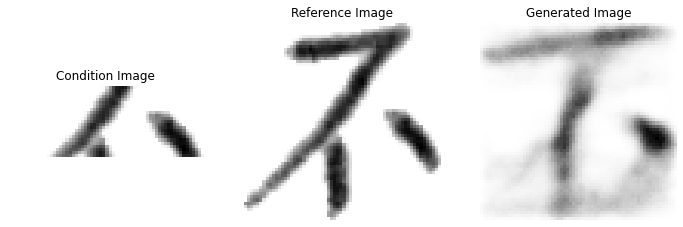

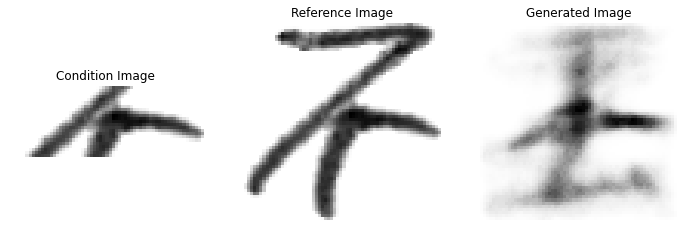

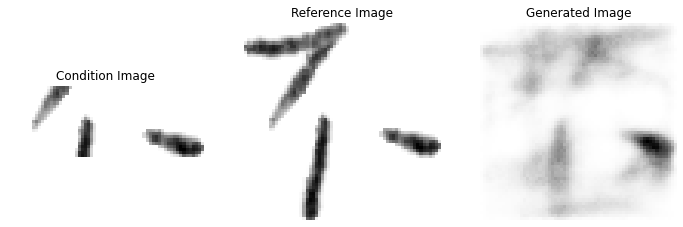

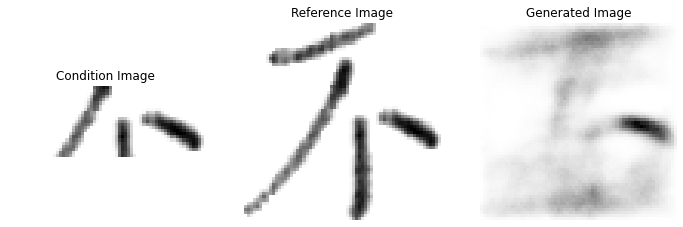

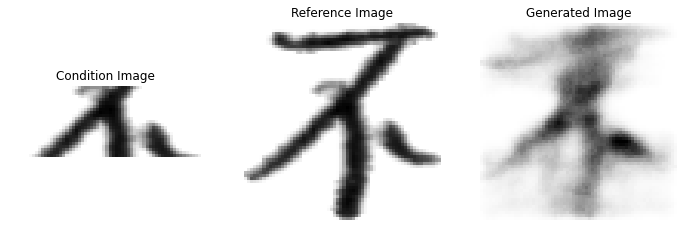

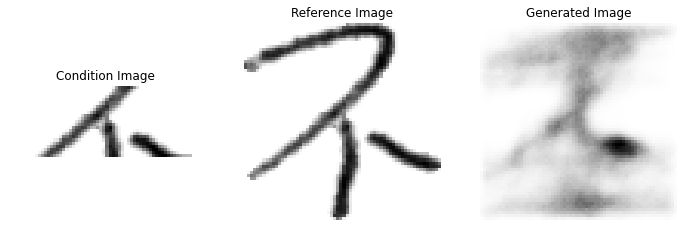

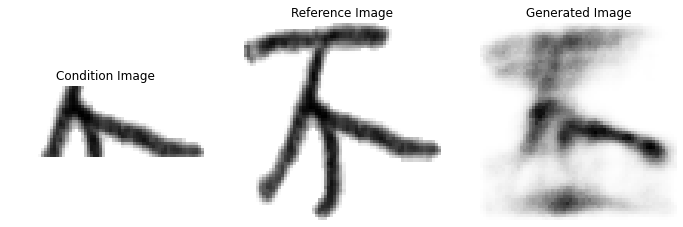

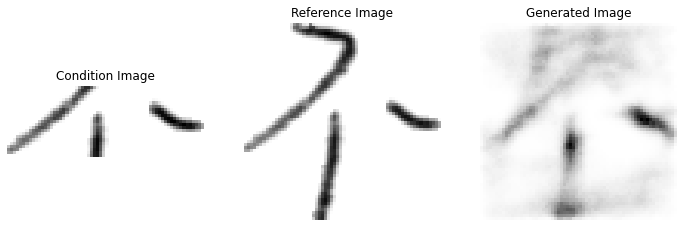

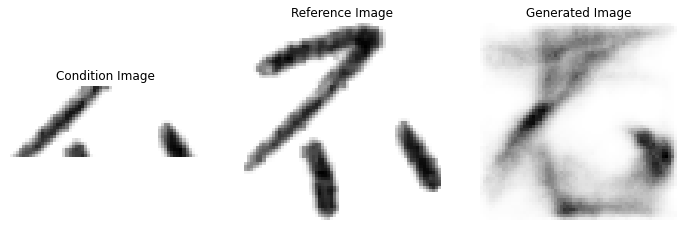

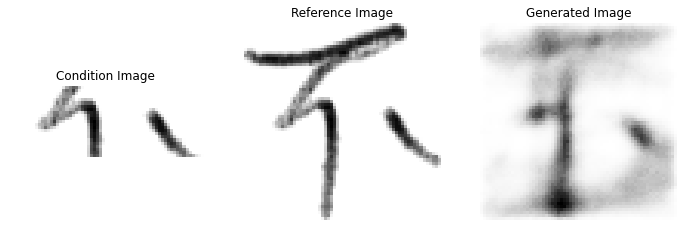

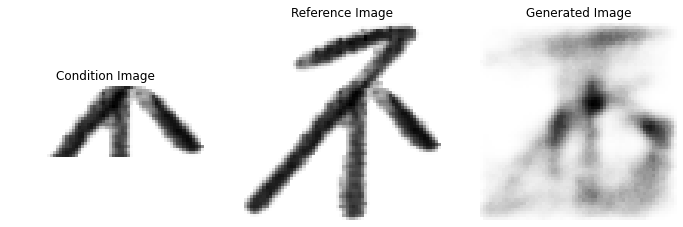

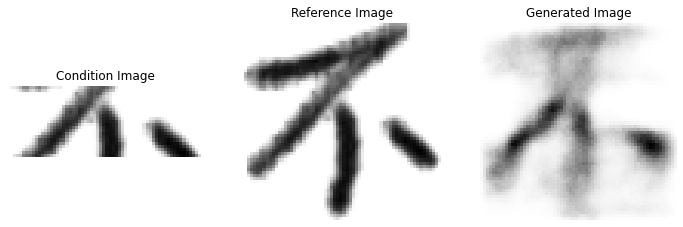

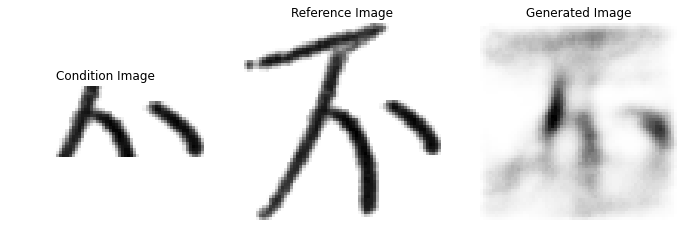

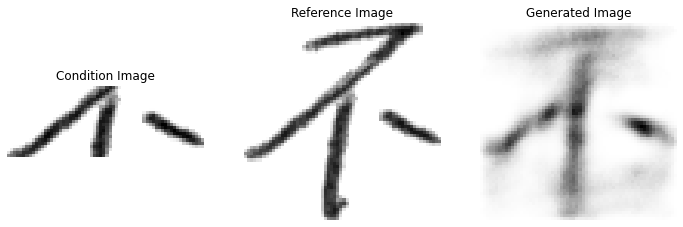

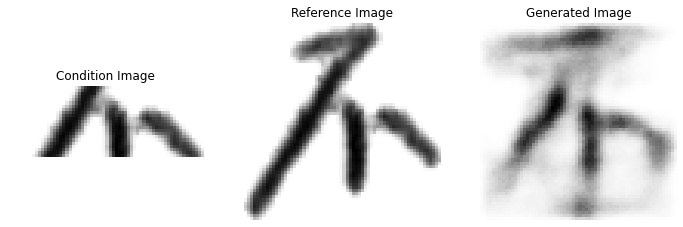

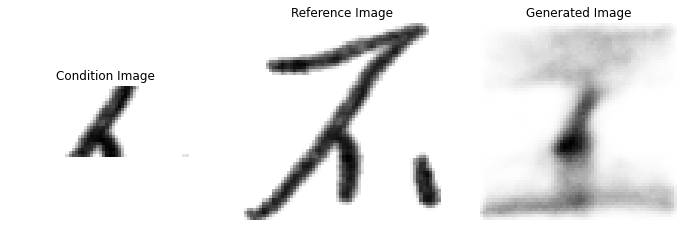

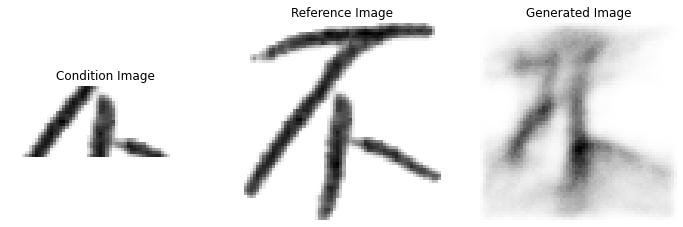

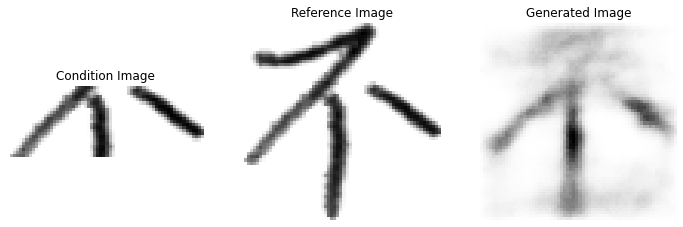

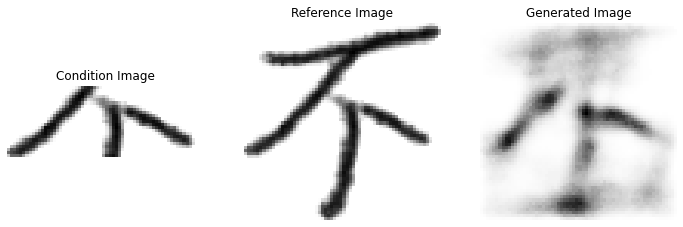

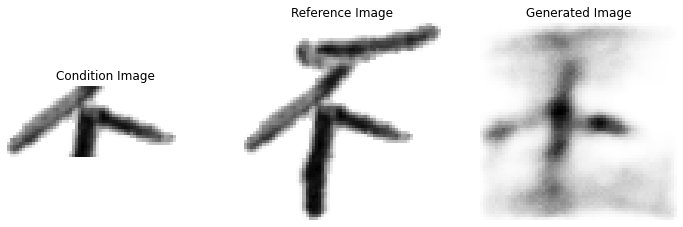

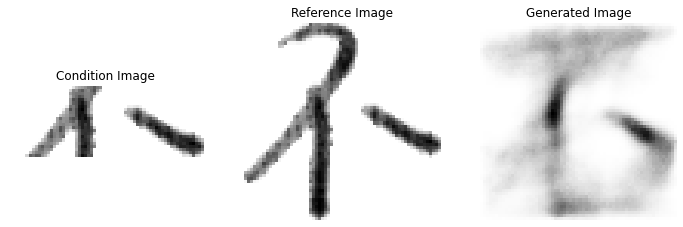

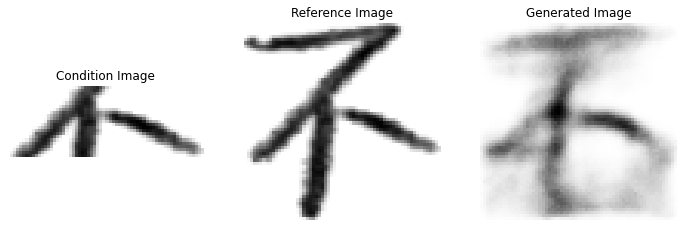

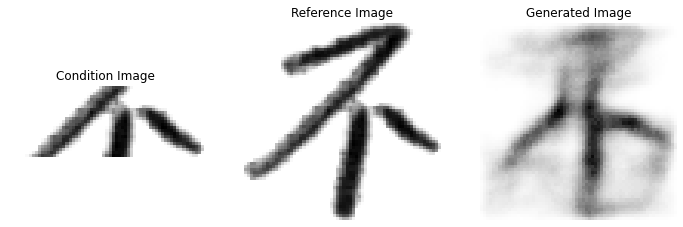

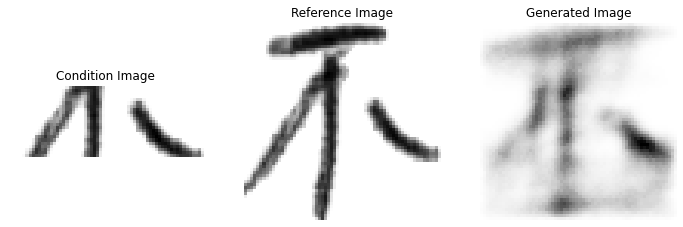

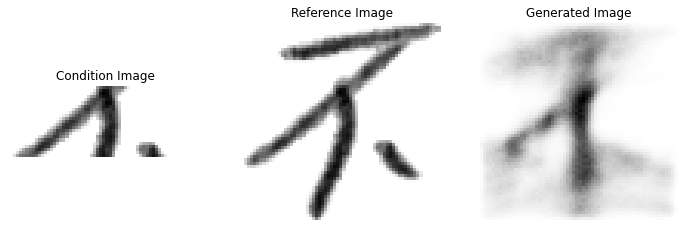

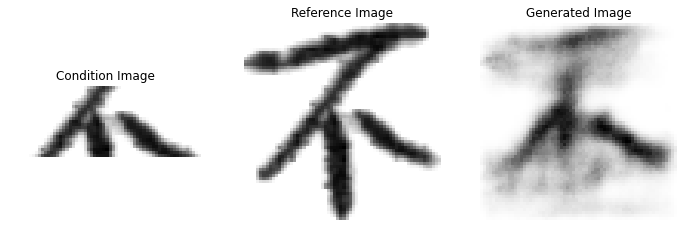

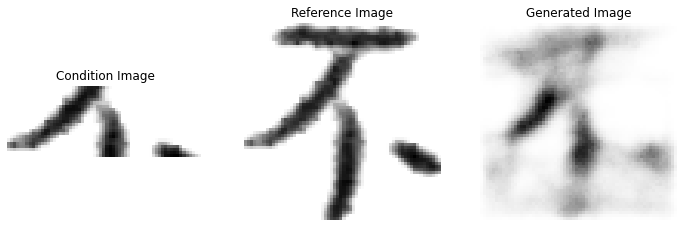

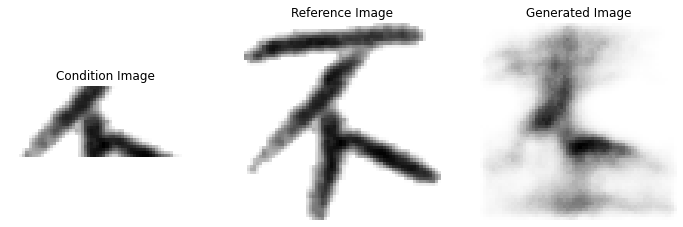

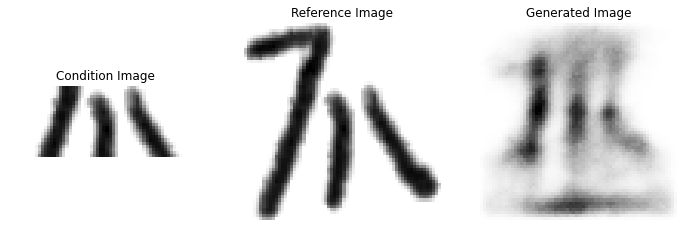

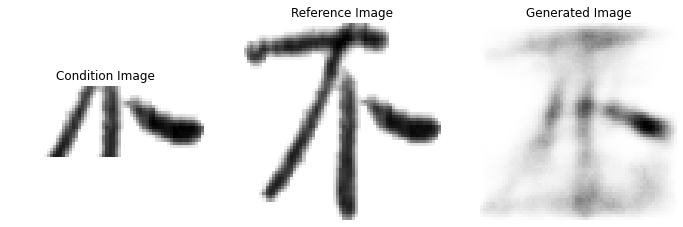

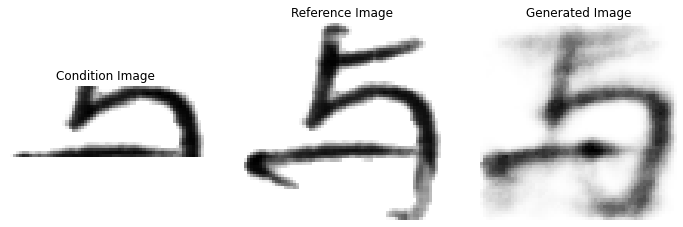

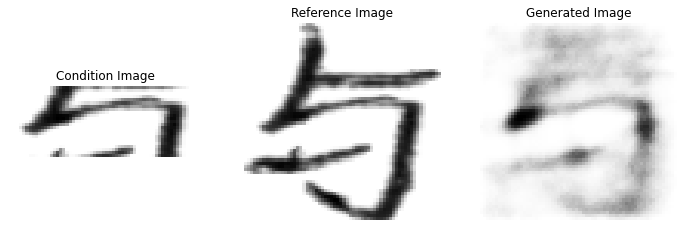

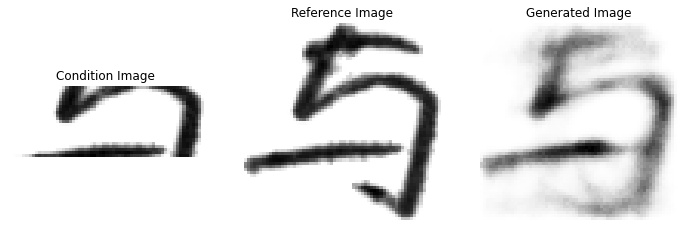

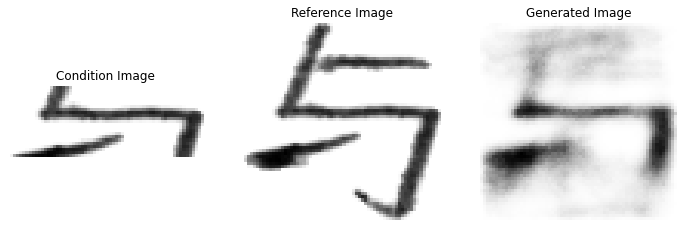

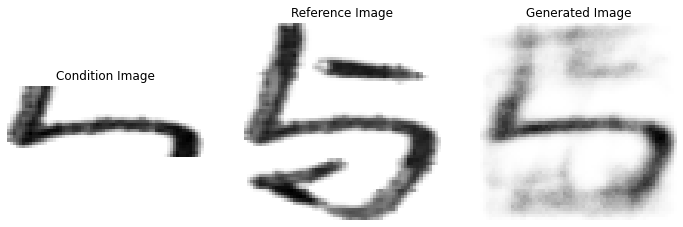

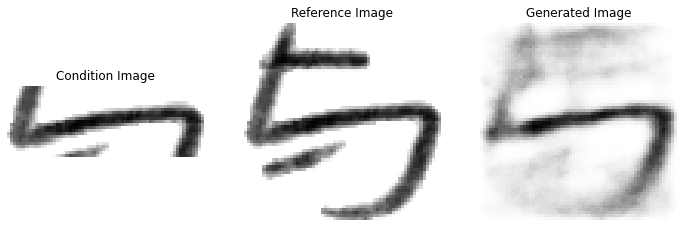

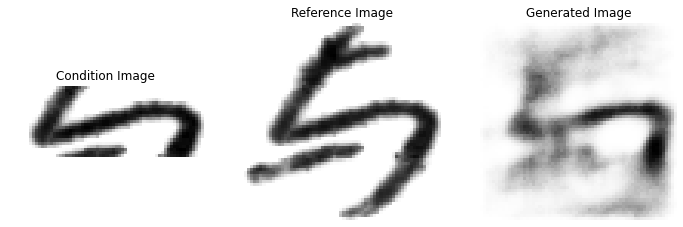

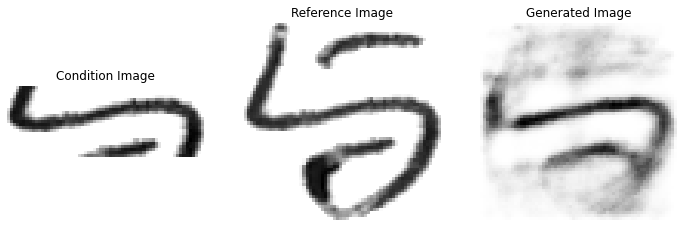

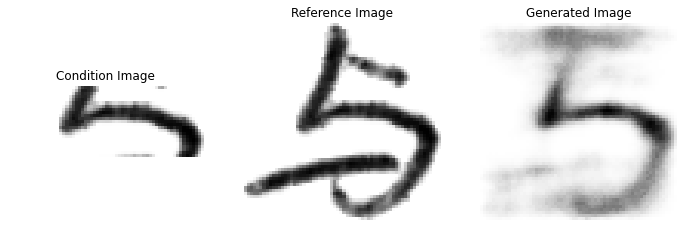

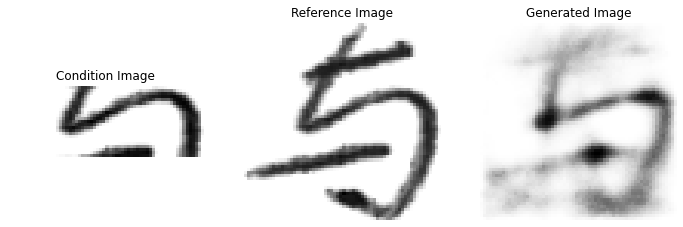

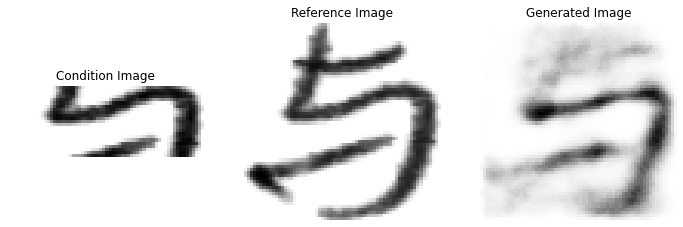

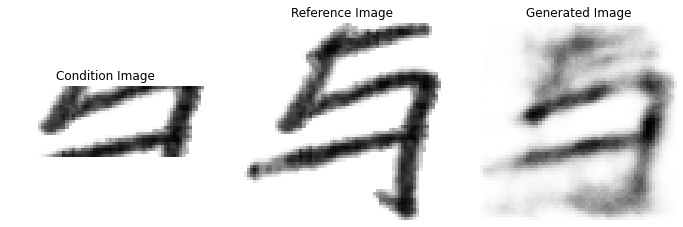

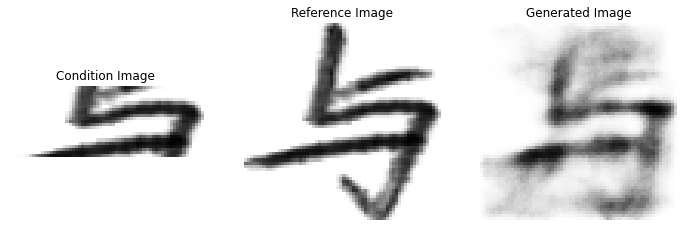

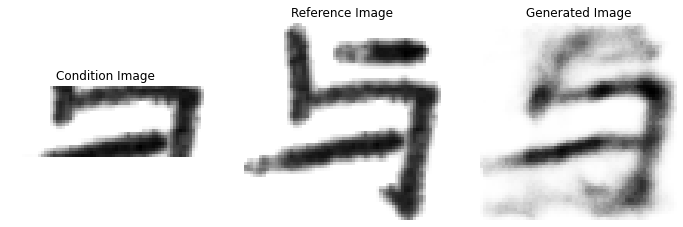

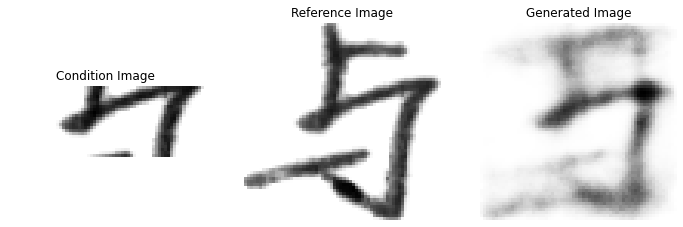

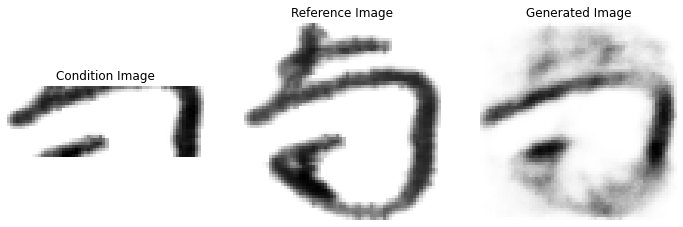

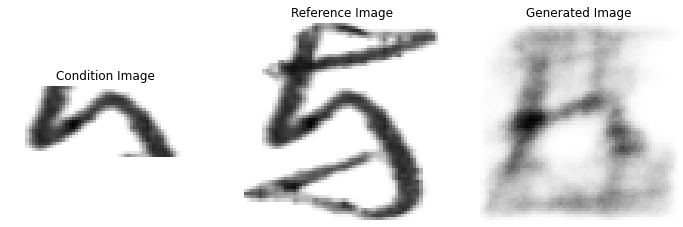

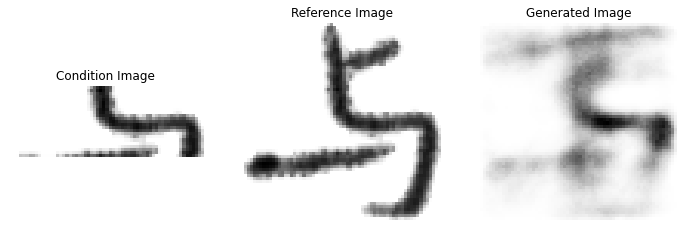

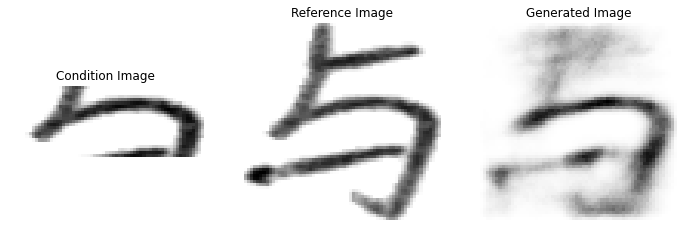

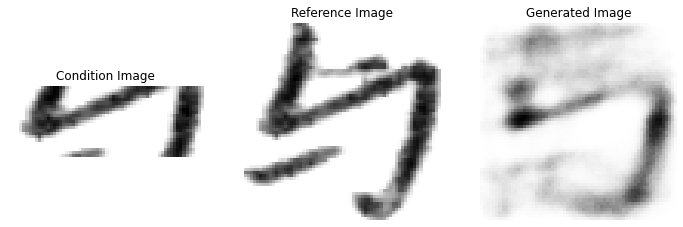

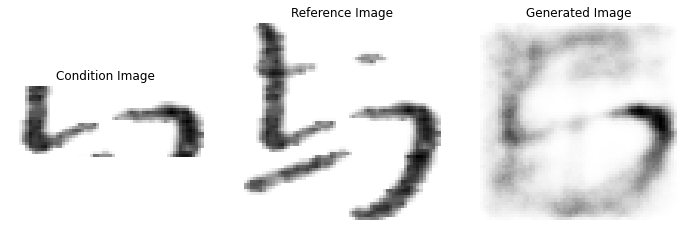

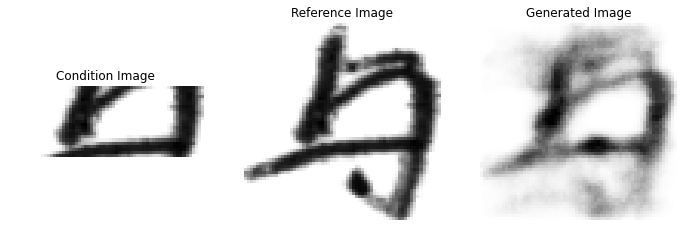

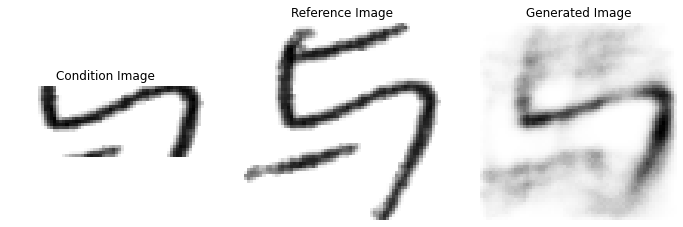

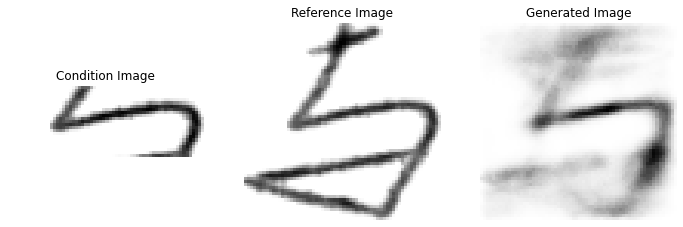

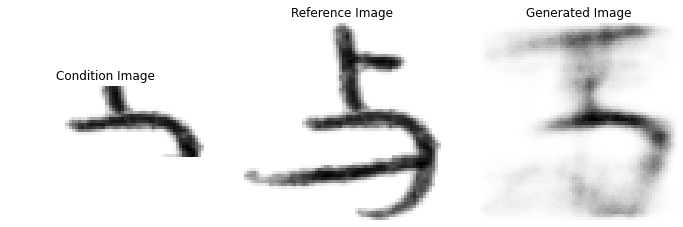

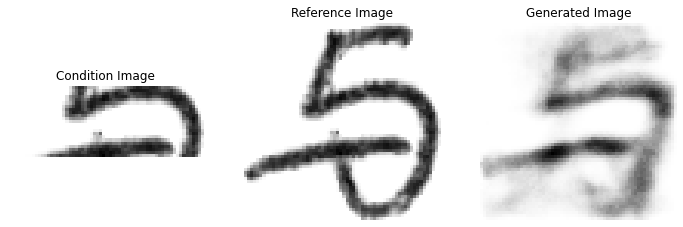

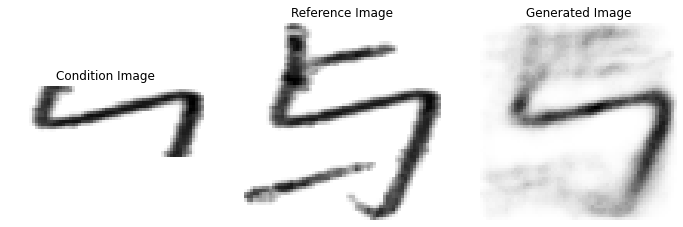

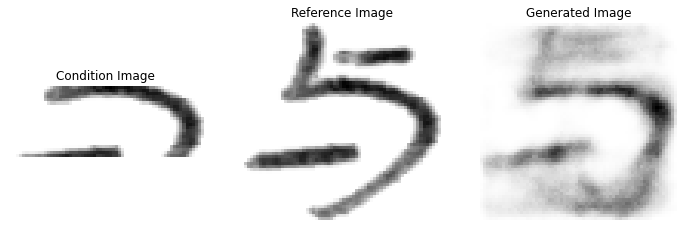

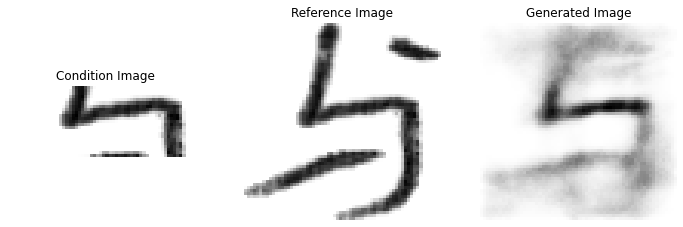

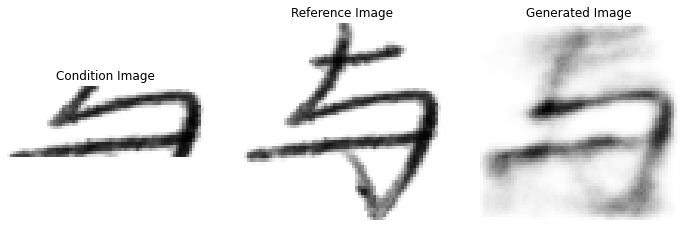

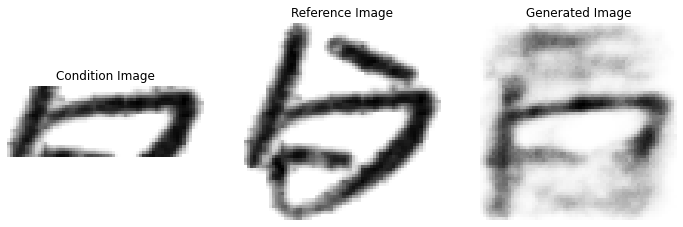

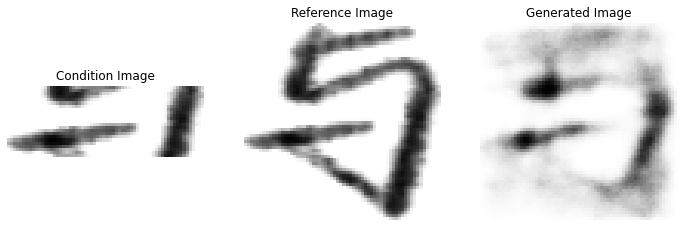

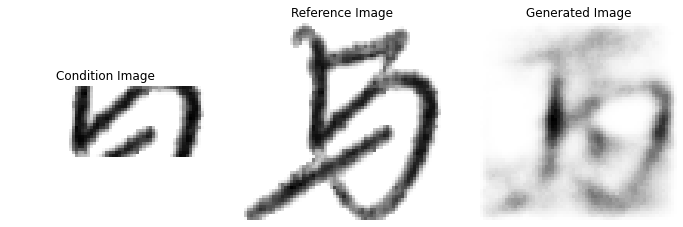

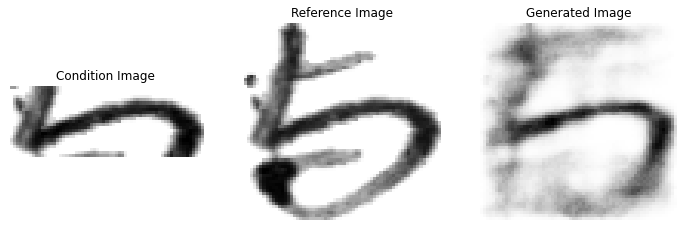

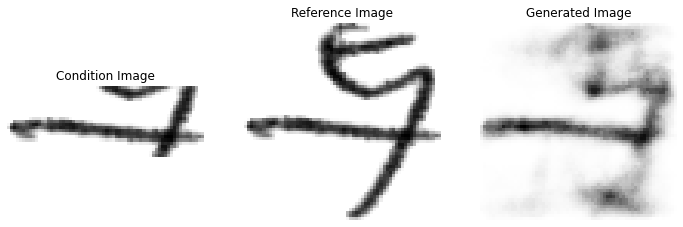

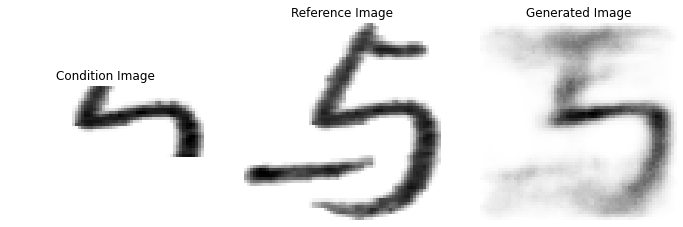

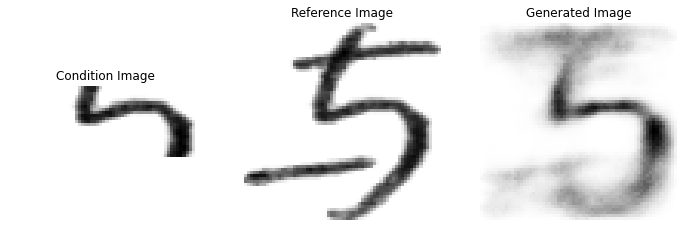

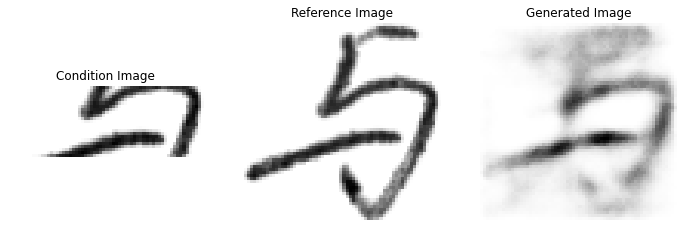

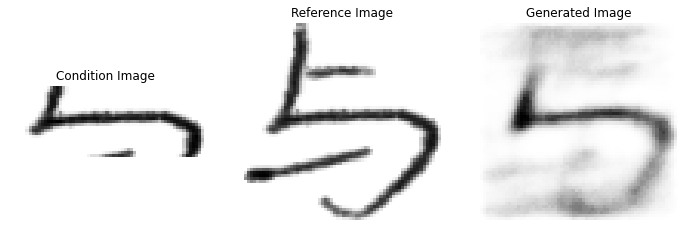

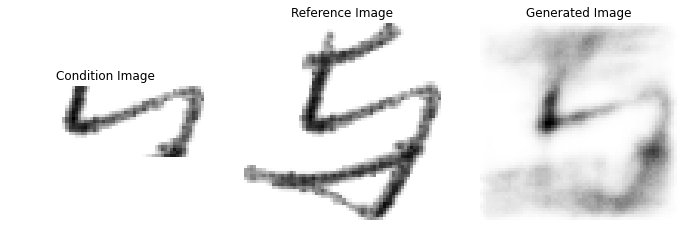

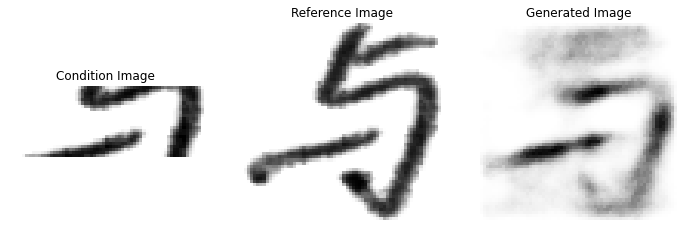

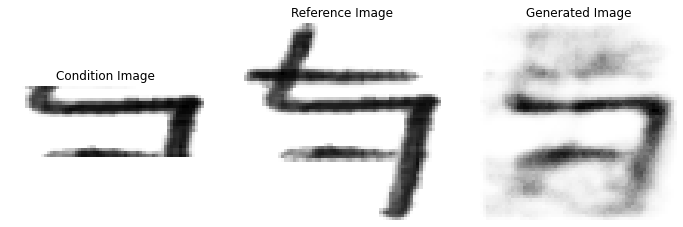

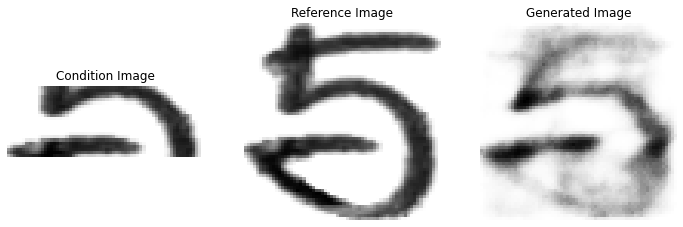

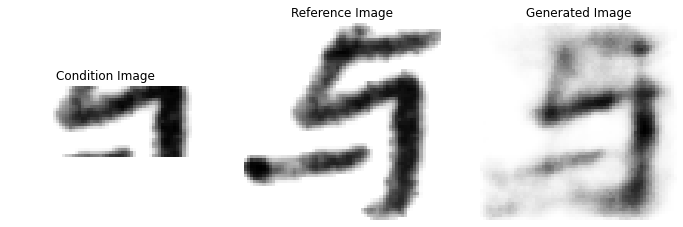

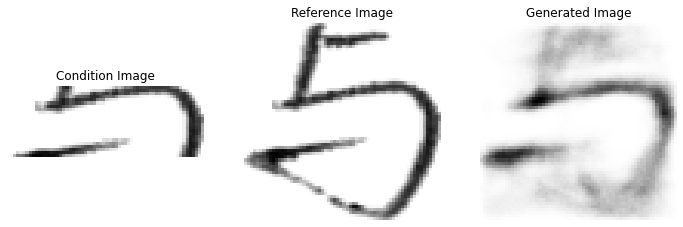

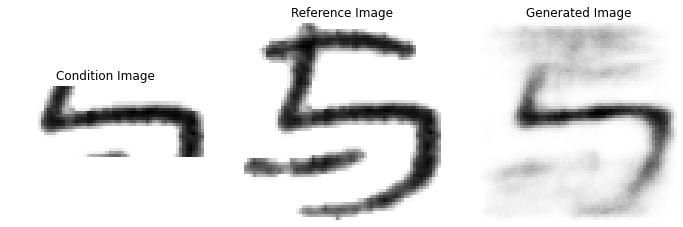

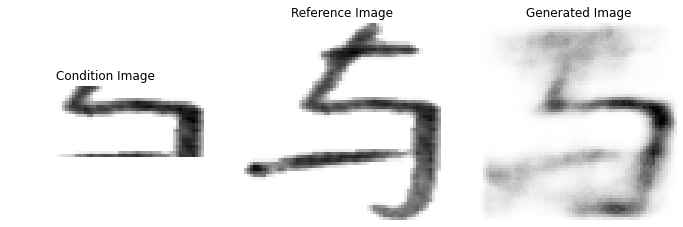

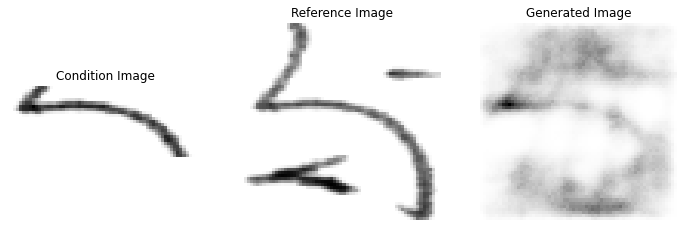

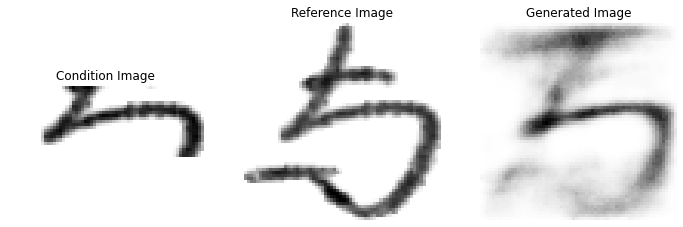

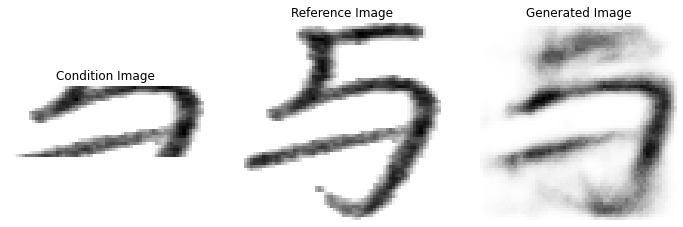

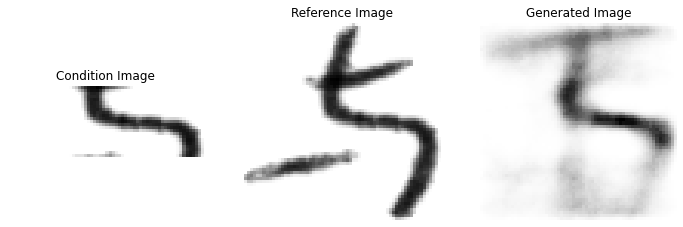

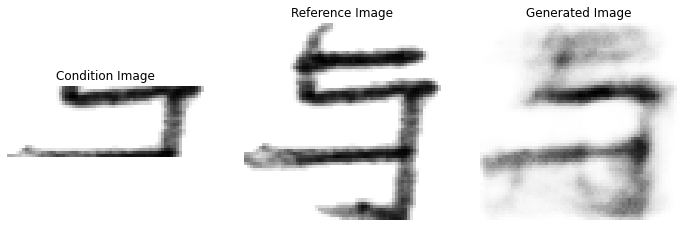

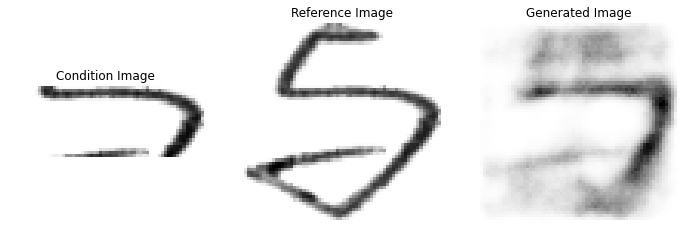

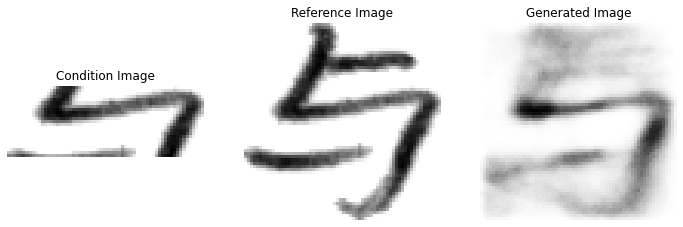

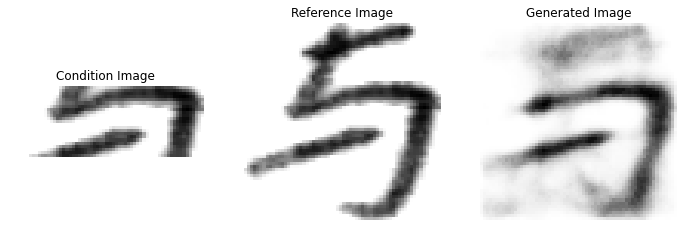

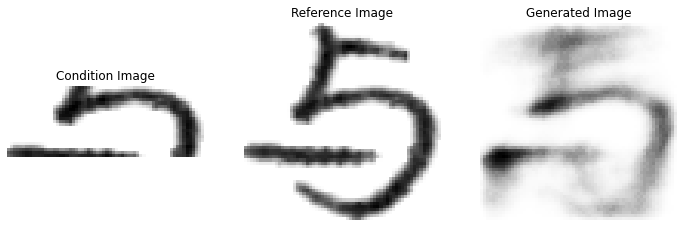

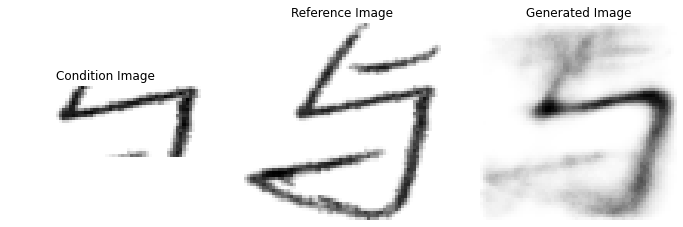

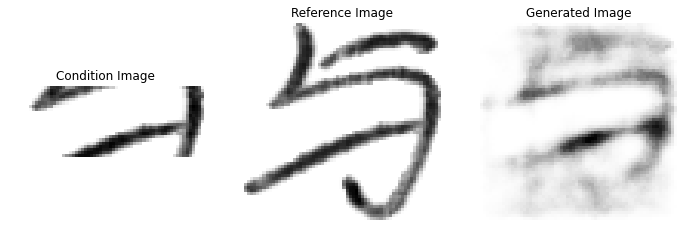

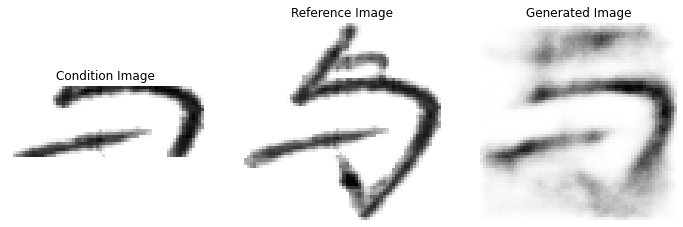

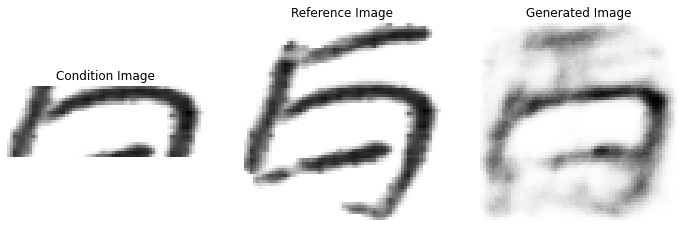

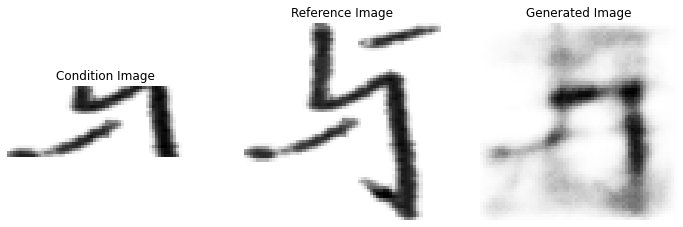

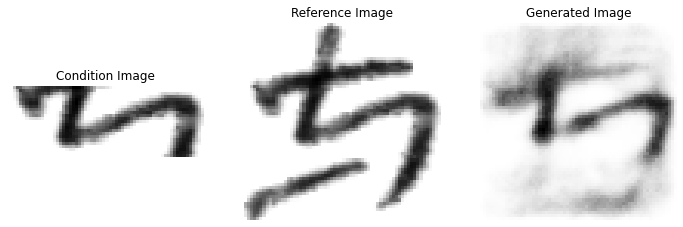

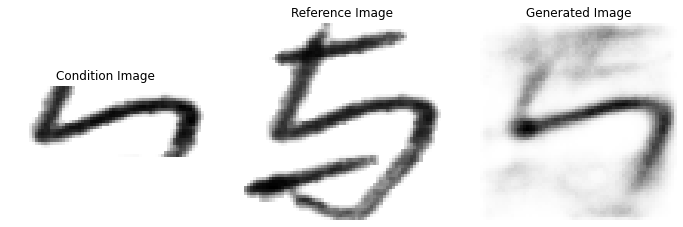

In [15]:
import matplotlib.pyplot as plt
import torch

def plot_generated_images(model, data_loader, num_images, batch_size, device='cpu'):
    model.eval()
    left_images = num_images
    with torch.no_grad():
        for batch_idx, (data, condition) in enumerate(data_loader):
            if batch_idx < 20:
                continue
            condition = condition.to(device)
            data = data.to(device)
            if left_images == 0:
                break
            
            z = torch.randn(batch_size, model.z_dim).to(device)
            cond_encoded = model.forward_condition_encoder(condition)
            sample = model.decode(z, cond_encoded).cpu()
            sample = sample.view(batch_size, 1, 64, 64)
            
            if left_images > batch_size:
                print_images = batch_size
                left_images = left_images-batch_size
            else:
                print_images = left_images
                left_images = 0

            for i in range(print_images):
                ref = data[i].cpu().detach().numpy().reshape(64, 64)
                img = sample[i].cpu().detach().numpy().reshape(64, 64)
                
                # Handle condition image with random shape
                cond = condition[i].cpu().detach().numpy()
                if len(cond.shape) > 2:
                    cond = cond[0]  # Select the first channel if condition is multi-channel
                cond_shape = cond.shape
                cond_resized = cond.reshape(cond_shape)

                plt.figure(figsize=(12, 4))

                # Plot condition image
                plt.subplot(1, 3, 1)
                plt.title('Condition Image')
                plt.imshow(cond_resized, cmap='gray')
                plt.axis('off')

                # Plot reference image
                plt.subplot(1, 3, 2)
                plt.title('Reference Image')
                plt.imshow(ref, cmap='gray')
                plt.axis('off')

                # Plot generated image
                plt.subplot(1, 3, 3)
                plt.title('Generated Image')
                plt.imshow(img, cmap='gray')
                plt.axis('off')

                plt.show()


plot_generated_images(model_cols, train_loader_cols, num_images=100, batch_size=32, device=device)